In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from survae import SurVAE, DEVICE
from survae.data import *
from survae.layer import *
from survae.calibrate import *

In [2]:
# number of points per image
N_POINTS = 30

In [3]:
smnist_dataset = SpatialMNIST(k=N_POINTS, flatten=False)

In [4]:
# This is a very hacky way of creating a layer that swaps the x- and y-components
# of the spatial data, which is needed for each step in the SMNIST architecture.
# I am sorry.
transposition_layer = OrthonormalLayer(2)
transposition_layer.o = nn.Parameter(torch.tensor([[0, 1], [1, 0]], dtype=torch.double), requires_grad=False)

In [7]:
sv_smnist = SurVAE(
    [
        [
            PermuteAxesLayer((1, 0)),
            BijectiveLayer((2, N_POINTS), [200, 200]),
            PermuteAxesLayer((1, 0)),
            transposition_layer,
            BijectiveLayer((N_POINTS, 2), [200, 200]),
            PermutationLayer()
        ]
        for _ in range(32)
    ] +
    [ReshapeLayer((2, N_POINTS), (2 * N_POINTS,))],
    name = "SV_SMNIST",
    condition_size = 10 # TODO: do we want it to be conditional?
)

In [8]:
train_log = sv_smnist.train(
    dataset=smnist_dataset,
    batch_size=1000,
    test_size=100,
    epochs=100,
    lr=1e-3,
    log_period=10,
    lr_decay_params=None,
    show_tqdm=True,
    save_path=None,
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [9]:
# save the model
torch.save(sv_smnist.state_dict(), "./saves/sv_smnist/model.pt")

### Plot loss

In [10]:
times = list(train_log.keys())
loss_train = [m.training_loss for m in train_log.values()]
loss_test = [m.testing_loss for m in train_log.values()]

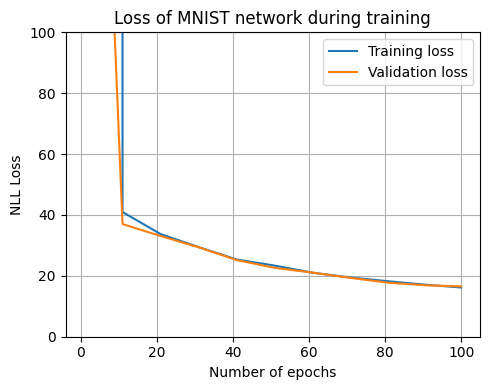

In [14]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## Calibration

In [15]:
X, y = smnist_dataset.sample(1_000, labels=True)
y = smnist_dataset.label_to_one_hot(y.long(), 10)

with torch.no_grad():
    Z = sv_smnist(X, y).cpu()

In [16]:
# calculate standard deviation
sigma = Z.std().item()
print(f"Standard deviation of code distribution is measured to be {sigma:.4f}")

Standard deviation of code distribution is measured to be 0.3879


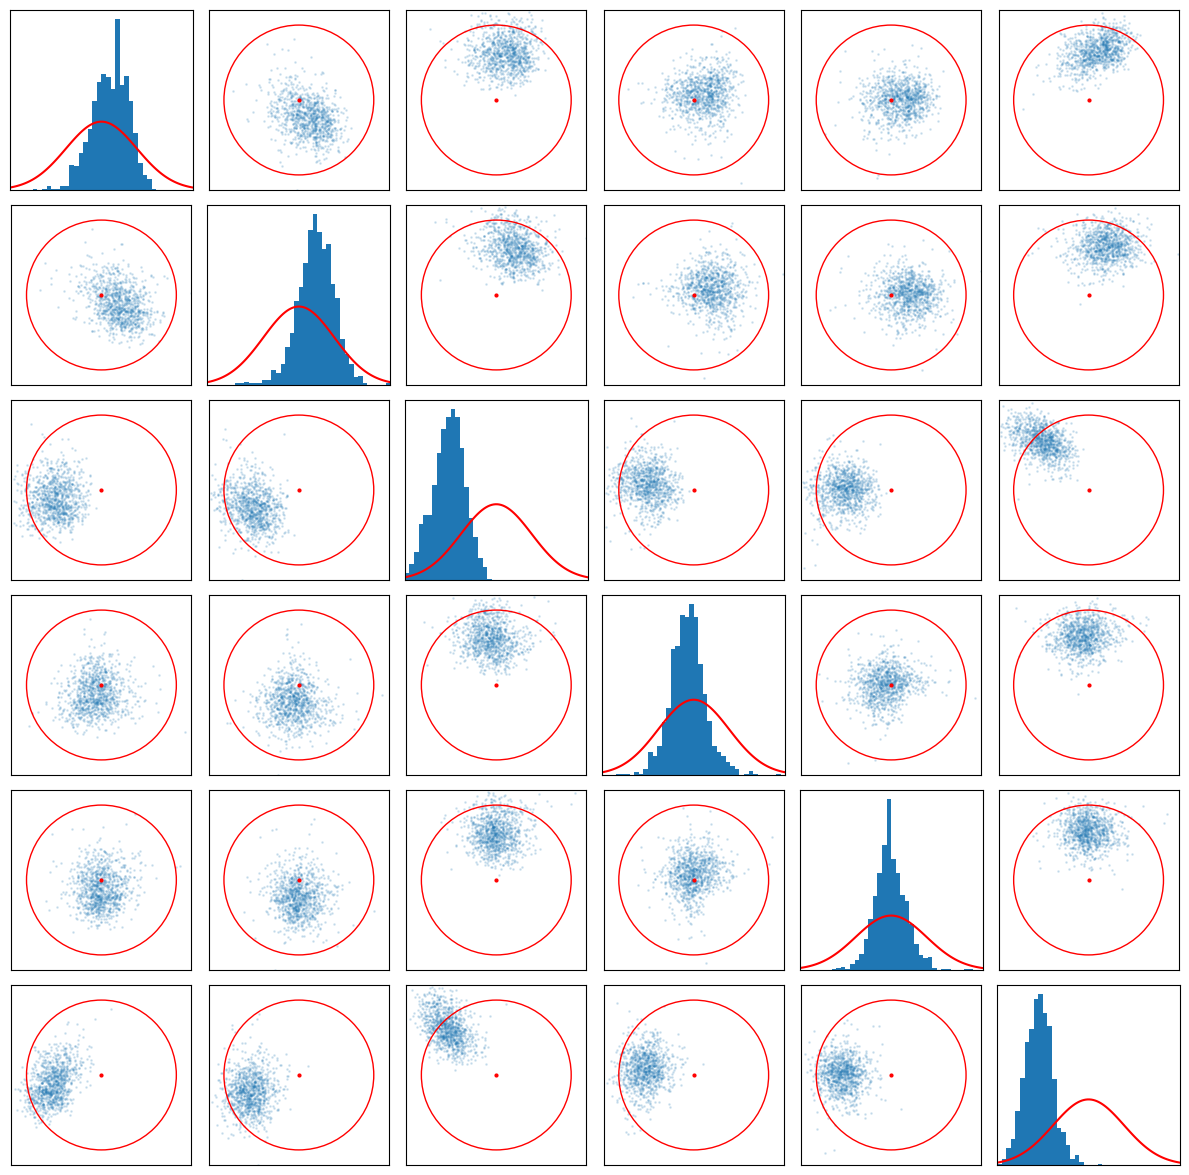

In [24]:
# randomly choose 6 dimensions to display
rp = torch.randperm(Z.shape[-1])[:6].cpu()
plot_learned_distribution(Z[:, rp], "", axis_scale=1, sigma=sigma)

## Sampling

In [25]:
ncols = 10
nrows = 4
plotsize = 1.5

In [26]:
# sample 1's
# _y = torch.tensor([1]).expand(ncols * nrows)

# sample every kind of number several times
_y = torch.arange(10).repeat(nrows)
print(_y)

y = smnist_dataset.label_to_one_hot(_y, 10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [27]:
# manually specify the standard deviation for the samples
Z_hat = torch.normal(0, sigma, size=(ncols * nrows, 2 * N_POINTS), device=DEVICE)
with torch.no_grad():
    X_hat = sv_smnist.backward(Z_hat, y).reshape(nrows, ncols, N_POINTS, 2).cpu()

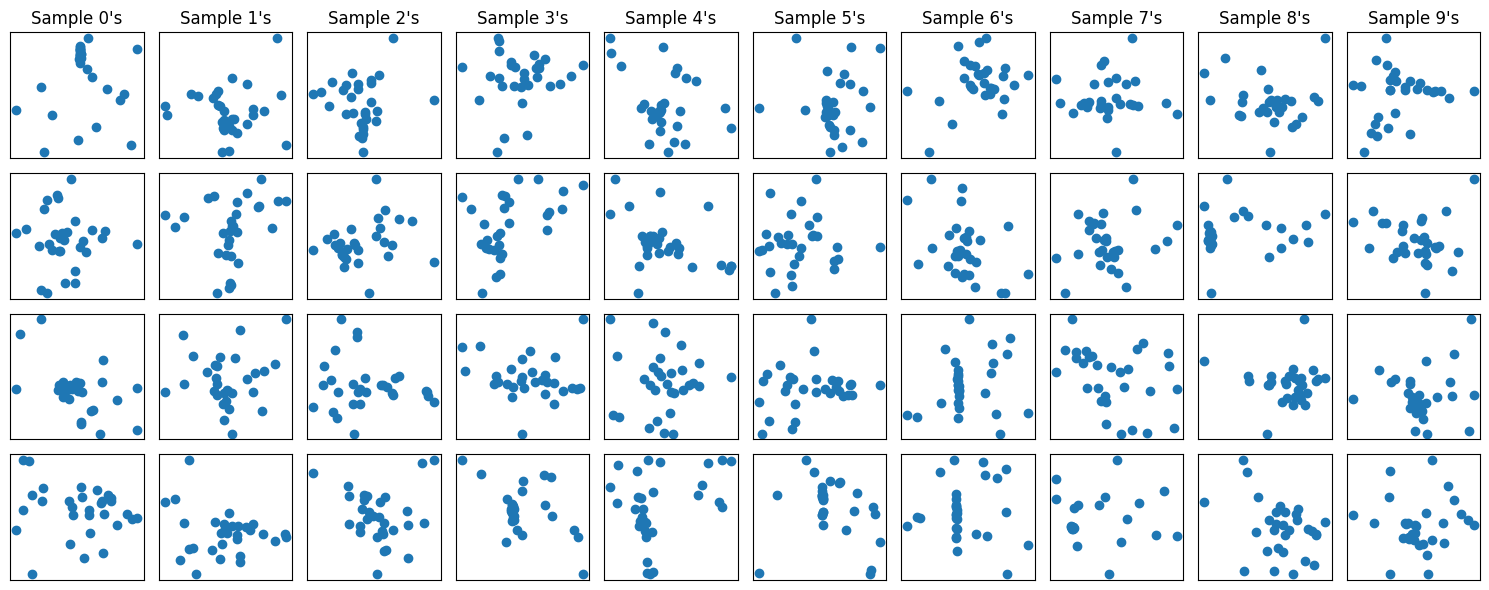

In [28]:
fig, ax = plt.subplots(nrows, ncols, figsize=(plotsize * ncols, plotsize * nrows))

for j in range(ncols):
    ax[0, j].set_title(f"Sample {j}'s")
    for i in range(nrows):
        _ax = ax[i, j]
        data = X_hat[i, j]
        _ax.scatter(data[:, 0], -data[:, 1])
        _ax.set_xticks([])
        _ax.set_yticks([])

plt.tight_layout()
plt.show()